# PCA + Information Theory for Business: A Practical Mini‑Tutorial

**Goal.** Show how to use **Principal Component Analysis (PCA)** and **Information Theory** (Mutual Information and mRMR) to **reduce dimensionality** and **improve clarity** in predictive projects. The example predicts **life expectancy** from macro indicators (Gapminder).

**Why should business teams care?**
- **Faster, simpler models:** fewer inputs → quicker iteration, lower costs.
- **Less noise, less overfitting:** keep what matters; drop the rest.
- **Explainability:** know which inputs *actually* reduce uncertainty about the outcome.

## What you will learn
1. **Prepare features**: log‑transform skewed columns, one‑hot encode categoricals, standardize continuous features safely (train‑only).
2. **PCA (unsupervised):** compress continuous variables while keeping ≥95% of their variance; inspect which variables drive each PC.
3. **Mutual Information (supervised):** rank features by how much they reduce uncertainty in the target; visualize **redundancy** and the **mRMR** trade‑off.
4. **Compare strategies:** All features vs **Top‑k MI**, **Top‑k mRMR**, and **PCA95%+Dummies** using **R²** and **RMSE**.
5. **Interpretation toolkit** (plots you’ll see):
   - **Explained‑variance bar chart** per PC (with top contributing variables)
   - **PC1×PC2 heatmap** colored by the target
   - **MI ranking** (and *normalized* MI for classification)
   - **Redundancy heatmap** (I(Xi;Xj))
   - **Relevance×Redundancy scatter** (mRMR intuition)
   - **Cumulative information curve** (knee point)
   - **Information Diagram** (2‑variable “Venn in bits”)
   - **Entropy waterfall** (multi‑feature chain‑rule view)
   - **Predicted vs Actual** scatter and R² bars

## How this notebook is organized
- **Functions:** documented helpers that build the feature matrix, run PCA/MI/mRMR, and generate the visuals.
- **Workflow:** load data → prepare features → split & scale → PCA/MI/mRMR → model & compare → interpret with visuals.
- **Business reading guide:**
  - PCA = compress **patterns** (doesn’t use the target).
  - MI/mRMR = pick inputs that **reduce uncertainty in the target** with minimal overlap.
  - The **best** choice depends on accuracy, cost, and explainability — you will compare results directly.

> Tip: keep PCA on **continuous** variables; use MI/mRMR on the **full set** (continuous + one‑hot dummies). Concatenate PCA scores with dummies when modeling.



### Setup
Import the Python libraries we’ll use for data handling (pandas/NumPy), visualization (matplotlib),
and modeling (scikit‑learn).


In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from textwrap import fill, shorten
from matplotlib.patches import Circle

### Function RMSE
`RMSE(y_true, y_pred)` returns the **Root Mean Squared Error** between actual and predicted values.

* It first tries `sklearn.metrics.mean_squared_error(..., squared=False)` (modern scikit-learn).
* If that keyword isn’t supported (older scikit-learn), it **falls back** to computing `sqrt(MSE)` manually.
* Result: a single number where **lower = better**; it’s in the **same units** as the target variable.

In [2]:
def RMSE(y_true, y_pred):
    """Compute Root Mean Squared Error with compatibility for older scikit-learn versions."""
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        import numpy as _np
        return _np.sqrt(mean_squared_error(y_true, y_pred))


### Function mrmr_greedy_regression
`mrmr_greedy_regression(X_df, y_arr, k)` selects **k features** using the **mRMR** (Minimum Redundancy–Maximum Relevance) heuristic for **regression**.

* **Relevance:** computes `mutual_info_regression` of each feature with the target $Y$; starts by picking the **most informative** feature.
* **Redundancy:** at each step, for every candidate feature it computes the **average MI** with the features already selected.
* **Greedy score:** `score = relevance − redundancy`; it adds the feature with the **highest score** until reaching `k`.

**Inputs:**

* `X_df`: DataFrame of features
* `y_arr`: target array
* `k`: number of features to select

**Output:**

* `selected`: ordered list of chosen feature names

> Note: This simple version assumes continuous features (uses `mutual_info_regression` everywhere) and estimates redundancy via **pairwise MI averages**; it’s a practical, fast heuristic rather than an exact optimizer.


In [3]:
def mrmr_greedy_regression(X_df: pd.DataFrame, y_arr: np.ndarray, k: int = 2) -> List[str]:
    """mrmr_greedy_regression function."""
    rel = mutual_info_regression(X_df.values, y_arr, random_state=0)
    rel = pd.Series(rel, index=X_df.columns)

    selected = [rel.idxmax()]
    candidates = [c for c in X_df.columns if c not in selected]

    while len(selected) < min(k, X_df.shape[1]):
        best_feat, best_score = None, -1e9
        for feat in candidates:
            reds = []
            x_feat = X_df[feat].values.reshape(-1, 1)
            for s in selected:
                mir = mutual_info_regression(x_feat, X_df[s].values, random_state=0)
                reds.append(mir[0])
            redundancy = float(np.mean(reds)) if reds else 0.0
            score = rel[feat] - redundancy
            if score > best_score:
                best_score = score
                best_feat = feat
        selected.append(best_feat)
        candidates.remove(best_feat)
    return selected


### Function plot_mi_ranking
`plot_mi_ranking(X, y, ...)` computes and visualizes a **Mutual Information (MI)** ranking of features against a target.

* **What it measures:** how much each feature **reduces uncertainty** about the target (`task="reg"` for regression, `"classif"` for classification).
* **Units:** MI can be shown in **bits** (default) or, for classification, as a **percentage of H(Y)** (`normalize_by_entropy=True`).
* **Discrete vs. continuous:** pass `discrete_features` (a boolean mask or `"auto"`) so the estimator treats **one-hot dummies as discrete** and numeric columns as continuous.
* **Display controls for many features:**

  * `max_bars`, `height_per_bar`, `min_fig_h`/`max_fig_h` make the chart readable even with dozens of variables.
  * `strip_prefixes` and `label_max_chars` shorten long dummy names (e.g., `country_...`).
  * `top_k` limits to the top features shown; the returned table still includes **all** features.
* **Output:** returns `(mi_df, fig, ax)` where `mi_df` is a sorted DataFrame with MI values; the plot is a **horizontal bar chart** (optional numeric `annotate` labels).

**Interpretation:** higher bars = features that **explain more** of the target on their own (univariate view). Use together with redundancy analyses (e.g., **mRMR**) to avoid picking overlapping signals.


In [4]:
def plot_mi_ranking(
    X, y,
    task="classif",
    top_k=None,
    discrete_features=False,
    n_neighbors=3,
    random_state=0,
    units="bits",
    normalize_by_entropy=False,
    annotate=False,
    figsize=(9, 5),             # largura fixa; altura pode ser auto
    fontsize=9,
    max_bars=40,
    height_per_bar=0.28,        # altura (em inches) por barra
    min_fig_h=4.0, max_fig_h=18.0,
    ytick_fontsize=None,        # se None, ajusta automaticamente
    label_max_chars=28,
    strip_prefixes=None,        # ex.: ["country_","region_"]
):

    """Plot a mutual information ranking of features vs. the target (bits or MI/H(Y) for classification)."""

    if isinstance(X, pd.DataFrame):
        feat_names = X.columns.tolist()
        Xv = X.values
    else:
        Xv = np.asarray(X)
        feat_names = [f"x{i}" for i in range(1, Xv.shape[1]+1)]

    y_arr = np.asarray(y)

# --- MI em nats
    if task == "classif":
        if not np.issubdtype(y_arr.dtype, np.number):
            y_arr = pd.Series(y_arr).astype("category").cat.codes.values
        mi_nats = mutual_info_classif(
            Xv, y_arr,
            discrete_features=discrete_features,
            n_neighbors=n_neighbors,
            random_state=random_state
        )
    else:
        mi_nats = mutual_info_regression(
            Xv, y_arr,
            discrete_features=discrete_features,
            n_neighbors=n_neighbors,
            random_state=random_state
        )

# --- MI em bits/nats
    mi_abs = mi_nats / np.log(2) if units == "bits" else mi_nats.copy()

    mi_over_hy = None
    if normalize_by_entropy and task == "classif":
        vals, counts = np.unique(y_arr, return_counts=True)
        p = counts / counts.sum()
        Hy_nats = -np.sum(p * np.log(p + 1e-15))
        mi_over_hy = (mi_nats / Hy_nats) if Hy_nats > 0 else mi_nats * 0.0
        mi_over_hy = np.clip(mi_over_hy, 0.0, 1.0)

# --- DF completo (sempre)
    mi_df = pd.DataFrame({"feature": feat_names, "MI": mi_abs})
    if mi_over_hy is not None:
        mi_df["MI_over_HY"] = mi_over_hy

    sort_col = "MI_over_HY" if mi_over_hy is not None else "MI"
    mi_df = mi_df.sort_values(sort_col, ascending=False).reset_index(drop=True)

    n_all = len(mi_df)
    n_plot = n_all
    if top_k is not None:
        n_plot = min(top_k, n_all)
    if max_bars is not None:
        n_plot = min(n_plot, max_bars)

    mi_df_plot = mi_df.head(n_plot).copy()

    def _strip(s: str) -> str:
        """_strip function."""
        if strip_prefixes:
            for pref in strip_prefixes:
                if s.startswith(pref):
                    s = s[len(pref):]
        return s

    def _short(s: str) -> str:
        """_short function."""
        s = _strip(s)
        if len(s) <= label_max_chars:
            return s
        k = max(3, label_max_chars - 1)
        left = k // 2
        right = k - left
        return f"{s[:left]}…{s[-right:]}"

    labels = [ _short(s) for s in mi_df_plot["feature"][::-1].values ]

# --- tamanho da figura (altura auto)
    fig_h = np.clip(min_fig_h if n_plot==0 else n_plot*height_per_bar,
                    min_fig_h, max_fig_h)
    fig, ax = plt.subplots(figsize=(figsize[1], fig_h))  # usa largura do tuple como altura? No: keep width
    fig.set_size_inches(figsize[0], fig_h)

# --- valores
    if mi_over_hy is None:
        values = mi_df_plot["MI"][::-1].values
        ax.barh(labels, values)
        ax.set_xlabel(f"Informação Mútua ({units})", fontsize=fontsize)
        title = "MI Ranking by variable"
        if annotate:
            for y_i,v in enumerate(values):
                ax.text(v, y_i, f"  {v:.3f}", va="center", fontsize=fontsize)
    else:
        values = (mi_df_plot["MI_over_HY"][::-1].values) * 100.0
        ax.barh(labels, values)
        ax.set_xlabel("MI / H(Y)  (%)", fontsize=fontsize)
        title = "MI Ranking normalized by H(Y)"
        if annotate:
            for y_i, v in enumerate(values):
                ax.text(v, y_i, f"  {v:.1f}%", va="center", fontsize=fontsize)

    if ytick_fontsize is None:
        ytick_fontsize = 7 if n_plot > 35 else (8 if n_plot > 25 else fontsize)
    ax.tick_params(axis='y', labelsize=ytick_fontsize)
    ax.set_title(title, fontsize=fontsize + 1)
    ax.grid(True, axis="x", alpha=0.3)
    plt.tight_layout()

# nota “+N outras”
    tail = n_all - n_plot
    if tail > 0:
        ax.text(0.99, -0.06, f"+{tail} outras (veja a tabela completa)",
                transform=ax.transAxes, ha="right", va="top", fontsize=fontsize-1)

    plt.show()
    return mi_df, fig, ax

### Function plot_pca_variance_with_top_features
`plot_pca_variance_with_top_features(pca, feature_names, ...)` draws a **bar chart of explained variance** for each principal component and annotates, for every PC, the **top-k original variables** (by absolute loading) with their **sign** (+/−).

**How to read it**

* Bar height = **proportion of variance explained** by that PC.
* Text for each PC lists variables that most shape the component (e.g., `income(+), co2(−)`).

**Key options**

* `top_k`: how many variables to list per PC.
* `annotate`: where to place the labels — `'above'` (default), `'inside'` (inside bars), or `'xtick'` (in the x-axis labels).
* `wrap`: wraps long labels onto multiple lines.
* `strip_prefixes` and `label_max_chars`: shorten long feature names (useful with one-hot columns like `country_*`).
* `pad_top`: adds headroom above the tallest bar so labels don’t collide with the title.
* `feature_names`: must match the **columns used to fit** the `pca` object (same order).


In [5]:
def plot_pca_variance_with_top_features(
    pca,
    feature_names,
    top_k=3,
    annotate='above',         # 'above' | 'inside' | 'xtick'
    wrap=28,
    figsize=(10, 5),
    fontsize=9,
    pad_top=0.25,
    label_max_chars=28,
    strip_prefixes=None,      # ex.: ['country_']
    title="Explained variance per principal component with top contributing variables per PC"
):
    evr = np.asarray(pca.explained_variance_ratio_)
    comps = np.asarray(pca.components_)
    feat_names = list(map(str, feature_names))

    
    def _short(s: str) -> str:
        """_short function."""
        if strip_prefixes:
            for pref in strip_prefixes:
                if s.startswith(pref):
                    s = s[len(pref):]
        if len(s) <= label_max_chars:
            return s
        k = max(3, label_max_chars - 1)
        left = k // 2
        right = k - left
        return f"{s[:left]}…{s[-right:]}"

    labels = []
    for i in range(comps.shape[0]):
        w = comps[i]
        idx = np.argsort(np.abs(w))[::-1][:top_k]
        parts = []
        for j in idx:
            sign = '+' if w[j] >= 0 else '−'
            parts.append(f"{_short(feat_names[j])}({sign})")
        text = ', '.join(parts)
        labels.append(fill(text, width=wrap) if wrap else text)

    x = np.arange(1, len(evr) + 1)

    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.bar(x, evr)
    ax.set_xticks(x)

    ymax = evr.max() * (1 + pad_top)
    ax.set_ylim(0, ymax)

    if annotate == 'xtick':
        ax.set_xticklabels([f"PC{i}\n{lbl}" for i, lbl in zip(x, labels)], rotation=0)
    elif annotate == 'inside':
        ax.set_xticklabels([f"PC{i}" for i in x])
        for b, txt in zip(bars, labels):
            xc = b.get_x() + b.get_width()/2
            y = b.get_height() * 0.96
            ax.text(xc, y, txt, ha='center', va='top', fontsize=fontsize, color='white', clip_on=True)
    else:  # 'above'
        ax.set_xticklabels([f"PC{i}" for i in x])
        y_off = evr.max() * pad_top * 0.6
        for b, txt in zip(bars, labels):
            xc = b.get_x() + b.get_width()/2
            y = b.get_height() + y_off
            ax.text(xc, y, txt, ha='center', va='bottom', fontsize=fontsize)

    ax.set_ylabel("Proportion of explained variance")
    ax.set_title(title, pad=fontsize*2)
    ax.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

### Function plot_pca_correlation_biplot

`plot_pca_correlation_biplot(pca, feature_names, ...)` draws a **PCA correlation circle (biplot)** for a chosen pair of components (default **PC1×PC2**). Each original variable appears as an **arrow**:

* **Direction** shows how the variable aligns with PC1/PC2.
* **Length** (arrow norm) indicates how strongly it **loads** on these PCs (longer = stronger).

**Inputs**

* `pca`: a fitted `sklearn.decomposition.PCA` (ideally on **standardized continuous** data).
* `feature_names`: names of the columns used to fit the PCA (same order).
* `components`: which PCs to plot, e.g., `(0, 1)` for PC1 vs PC2.
* `top_k` / `min_norm`: keep only the **most impactful** arrows to reduce clutter.
* `discrete_mask`: optional boolean mask to style **discrete/dummy** variables differently.

**Plot details**

* Draws a **unit circle** reference; arrows outside/near the circle indicate strong relationships with the shown PCs.
* Axis labels include **percent variance explained** by each PC.
* Returns `(fig, ax)` for further customization.

**Interpretation**

* Variables pointing in **similar directions** are **positively correlated**; opposite directions suggest **negative correlation**.
* A variable with a **long arrow** near the PC1 axis contributes more to **PC1**; near PC2 axis contributes more to **PC2**.



In [6]:
def plot_pca_correlation_biplot(
    pca,
    feature_names,
    components=(0, 1),
    top_k=None,                 # mostra apenas as top-k por comprimento da seta
    min_norm=None,
    discrete_mask=None,
    label_wrap=28,
    annotate=True,
    figsize=(7, 7),
    title=None,
):
    """
    PCA correlation circle (biplot) for a pair of components with variable loadings.
    Correlation circle / biplot (PC1×PC2) com vetores das variáveis.
    IMPORTANTE: o PCA deve ter sido ajustado em dados CONTÍNUOS padronizados (z-score).

    pca: sklearn.decomposition.PCA já ajustado
    feature_names: nomes das colunas usadas no fit do PCA (na mesma ordem)
    components: par de PCs a exibir (ex.: (0,1) para PC1×PC2)
    top_k/min_norm: filtros para reduzir poluição visual
    discrete_mask: marca variáveis discretas (se quiser diferenciar estilo)
    """
    c1, c2 = components
    evr = np.asarray(pca.explained_variance_ratio_)
    load = pca.components_.T * np.sqrt(pca.explained_variance_)
    L = load[:, [c1, c2]]  # (n_features, 2)

    norms = np.linalg.norm(L, axis=1)

    idx_all = np.arange(len(feature_names))
    if top_k is not None:
# pega top-k por comprimento
        keep = idx_all[np.argsort(-norms)[:top_k]]
    else:
        keep = idx_all
    if min_norm is not None:
        keep = keep[norms[keep] >= float(min_norm)]

    feat = np.array(list(map(str, feature_names)))[keep]
    V = L[keep]
    norms_keep = norms[keep]

# plot
    fig, ax = plt.subplots(figsize=figsize)

    ax.add_patch(Circle((0, 0), 1.0, fill=False, ls="--", lw=1.2, alpha=0.6))
    ax.add_patch(Circle((0, 0), 0.5, fill=False, ls=":", lw=1.0, alpha=0.4))

# eixos
    ax.axhline(0, lw=1, alpha=0.4)
    ax.axvline(0, lw=1, alpha=0.4)

# setas
    for i, (name, (x, y)) in enumerate(zip(feat, V)):
        kw = {}
        if discrete_mask is not None:
            is_disc = bool(discrete_mask[keep[i]])
            kw["alpha"] = 0.9 if not is_disc else 0.7
            kw["lw"] = 1.6 if not is_disc else 1.0
        ax.arrow(0, 0, x, y, length_includes_head=True,
                 head_width=0.03, head_length=0.05, **kw)

        if annotate:
            txt = fill(name, width=label_wrap) if label_wrap else name
            ax.text(x * 1.07, y * 1.07, txt, ha="center", va="center", fontsize=9)

    ax.set_xlim(-1.15, 1.15)
    ax.set_ylim(-1.15, 1.15)
    ax.set_aspect("equal", adjustable="box")

    ax.set_xlabel(f"PC{c1+1} ({evr[c1]*100:.1f}% variance)")
    ax.set_ylabel(f"PC{c2+1} ({evr[c2]*100:.1f}% variance)")
    ax.set_title(title or "PCA correlation circle (loadings on PC1–PC2)")
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    return fig, ax


### Function: assemble the design matrix
Build the final matrices (continuous z-scored + dummy 0/1) and the aligned discrete mask.


In [7]:
def assemble_matrix(X_raw, scaler, cont_cols, dum_cols):
    """Assemble a standardized design matrix (continuous z-scored + dummy 0/1) and its discrete mask."""
    if scaler is not None and len(cont_cols) > 0:
        Xc = pd.DataFrame(scaler.transform(X_raw[cont_cols].values), columns=cont_cols, index=X_raw.index)
    else:
        Xc = X_raw[cont_cols].copy()
    Xd = X_raw[dum_cols].copy() if len(dum_cols) > 0 else pd.DataFrame(index=X_raw.index)
    X_all = pd.concat([Xc, Xd], axis=1)
# discrete mask aligned to X_all columns
    discrete_mask = np.array([False]*len(cont_cols) + [True]*len(dum_cols), dtype=bool)
    return X_all, discrete_mask


### PC1×PC2 heatmap colored by the target
In the PCA plane, color each cell with the average target value to reveal structure tied to outcomes.


In [8]:
def plot_pca_heatmap_pc1_pc2_stat(
    X_pca,
    pca,
    feature_names,
    z,
    z_label="life_exp",
    stat="mean",         # "mean", "sum" ou "count"
    bins=40,
    top_k=3,
    wrap=42,
    figsize=(8,6),
    fontsize=9
):
    """PC1×PC2 heatmap where color encodes a target statistic (e.g., mean of life_exp)."""
    if X_pca.shape[1] < 2:
        raise ValueError("Precisa de pelo menos 2 PCs.")
    pc1, pc2 = X_pca[:, 0], X_pca[:, 1]

    evr = np.asarray(pca.explained_variance_ratio_)
    comps = np.asarray(pca.components_)
    feat_names = list(map(str, feature_names))

    def _top(pc_idx):
        """_top function."""
        w = comps[pc_idx]
        idx = np.argsort(np.abs(w))[::-1][:top_k]
        return ", ".join([f"{feat_names[j]}({'+' if w[j]>=0 else '−'})" for j in idx])

    xlab = fill(f"PC1 ({evr[0]*100:.1f}% var)\n{_top(0)}", width=wrap) if wrap else f"PC1 ({evr[0]*100:.1f}% var)\n{_top(0)}"
    ylab = fill(f"PC2 ({evr[1]*100:.1f}% var)\n{_top(1)}", width=wrap) if wrap else f"PC2 ({evr[1]*100:.1f}% var)\n{_top(1)}"

# Definir bins
    if isinstance(bins, int):
        xedges = np.linspace(pc1.min(), pc1.max(), bins+1)
        yedges = np.linspace(pc2.min(), pc2.max(), bins+1)
    else:
# permite tuple/list ou arrays de bordas
        if isinstance(bins, (tuple, list)) and len(bins) == 2:
            xedges, yedges = bins
        else:
            raise ValueError("bins deve ser int ou (xedges, yedges).")

# contagem:
    N, _, _ = np.histogram2d(pc1, pc2, bins=[xedges, yedges])
    if stat == "count":
        Z = N
    else:
        S, _, _ = np.histogram2d(pc1, pc2, bins=[xedges, yedges], weights=z)
        if stat == "sum":
            Z = S
        elif stat == "mean":
            with np.errstate(invalid="ignore", divide="ignore"):
                Z = S / N
        else:
            raise ValueError("stat deve ser 'mean', 'sum' ou 'count'.")

    Z = np.ma.masked_where(N == 0, Z)

# Plot
    fig, ax = plt.subplots(figsize=figsize)
    mesh = ax.pcolormesh(xedges, yedges, Z.T, shading="auto")
    cbar = plt.colorbar(mesh, ax=ax)
    cbar.set_label(f"{z_label} ({stat})", fontsize=fontsize)

    ax.set_xlabel(xlab, fontsize=fontsize)
    ax.set_ylabel(ylab, fontsize=fontsize)
    ax.set_title("PC1 × PC2 — target heatmap", fontsize=fontsize+1)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    return fig, ax


### Function build_feature_matrix_gapminder
Helper to create a model‑ready table: apply log transforms to skewed continuous variables,
one‑hot encode categoricals, and return a mask marking discrete columns (dummies).


In [9]:
def build_feature_matrix_gapminder(
    df: pd.DataFrame,
    target: str = "life_exp",
    log_cols=("income", "co2", "population"),
    categorical="auto",
    drop_first: bool = True,     # evita colinearidade
    standardize_cont: bool = False
):
    """Build a model-ready feature matrix with one-hot encoding, optional log transforms, and a discrete mask."""
    df = df.copy()

    if target not in df.columns:
        raise ValueError(f"Coluna alvo '{target}' não encontrada.")
    y = df[target].values

    if categorical == "auto":
        cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
        if target in cat_cols:
            cat_cols.remove(target)
    else:
        cat_cols = [c for c in categorical if c in df.columns and c != target]

    num_cols = [c for c in df.columns if c not in cat_cols and c != target]

    num_df = df[num_cols].copy()
    for c in log_cols:
        if c in num_df.columns:
            num_df[c] = num_df[c].astype(float).clip(lower=1e-9)
            num_df[c] = np.log10(num_df[c])

    if standardize_cont and len(num_df.columns) > 0:
        scaler = StandardScaler().fit(num_df.values)
        num_z = pd.DataFrame(scaler.transform(num_df.values), columns=num_df.columns, index=num_df.index)
    else:
        scaler = None
        num_z = num_df

    dummies = pd.get_dummies(df[cat_cols], drop_first=drop_first, dtype=np.uint8) if len(cat_cols) > 0 else pd.DataFrame(index=df.index)

    X_enc = pd.concat([num_z, dummies], axis=1)
    discrete_mask = np.array([False]*num_z.shape[1] + [True]*dummies.shape[1], dtype=bool)

    meta = {
        "continuous_cols": num_z.columns.tolist(),
        "ohe_cols": dummies.columns.tolist(),
        "discrete_mask": discrete_mask,
        "scaler": scaler
    }
    return X_enc, y, meta

### Function eval_models_reg
Train Linear Regression and Random Forest, report R² and RMSE — simple, business‑friendly metrics.

In [10]:
def eval_models_reg(Xtr, Xte, ytr, yte, tag: str) -> dict:
    """eval_models_reg function."""
    out = {}

    t0 = time.perf_counter()
    lr = LinearRegression()
    lr.fit(Xtr, ytr)
    yhat = lr.predict(Xte)
    out[f"{tag} | LR R2"] = (r2_score(yte, yhat), time.perf_counter() - t0)
    out[f"{tag} | LR RMSE"] = (RMSE(yte, yhat), None)

    t0 = time.perf_counter()
    rf = RandomForestRegressor(n_estimators=300, random_state=0, n_jobs=-1)
    rf.fit(Xtr, ytr)
    yhat = rf.predict(Xte)
    out[f"{tag} | RF R2"] = (r2_score(yte, yhat), time.perf_counter() - t0)
    out[f"{tag} | RF RMSE"] = (RMSE(yte, yhat), None)
    return out


### Function get_sets_for_tag

`get_sets_for_tag(tag)` is a small **helper** that maps a **strategy label** (e.g., `"All | LR R2"`, `"Top-10 mRMR | RF R2"`) to the corresponding **train/test feature matrices**:

* `"All"` → returns `Xa_tr, Xa_te`
* `"Top-… MI"` → returns `Xmi_tr, Xmi_te`
* `"Top-… mRMR"` → returns `Xmrmr_tr, Xmrmr_te`
* anything else (e.g., `"PCA95%+Dummies"`) → returns `Xpca_tr, Xpca_te`

It parses the part **before** `" | "` in the tag and selects the right matrices so the later code can fit/evaluate the chosen strategy without `if/else` clutter.



In [11]:
def get_sets_for_tag(tag: str):
    """get_sets_for_tag function."""
    key = tag.split(" | ")[0]
    if key == "All":
        return Xa_tr, Xa_te
    elif key.startswith("Top-") and "MI" in key:
        return Xmi_tr, Xmi_te
    elif key.startswith("Top-") and "mRMR" in key:
        return Xmrmr_tr, Xmrmr_te
    else:
        return Xpca_tr, Xpca_te


### Function _entropy_bits_from_codes

`_entropy_bits_from_codes(c)` computes the **Shannon entropy** of a **discrete** variable in **bits**.

* Expects `c` to be a vector of **category codes** (integers); it **drops NaNs** and converts to `int`.
* Builds the empirical distribution (counts → probabilities) and computes

  $$
  H = -\sum_i p_i \log_2 p_i
  $$
* Filters out zero-probability terms (avoids `log(0)`), and returns `0.0` if the input is empty.

Use it whenever you need the **uncertainty of a categorical/discretized variable** (e.g., for information diagrams or entropy waterfalls).


In [12]:
# --- helpers de entropia/MI discretas (em bits) ---
def _entropy_bits_from_codes(c):
    """_entropy_bits_from_codes function."""
    c = pd.Series(c).dropna().astype(int).values
    if c.size == 0:
        return 0.0
    vals, cnt = np.unique(c, return_counts=True)
    p = cnt / cnt.sum()
    p = p[p > 0]
    return float(-(p * np.log2(p)).sum())


### Function _mi_bits_from_codes

`_mi_bits_from_codes(x, y)` computes the **mutual information** $I(X;Y)$ between two **discrete-coded** variables in **bits**.

* Cleans inputs: converts `x` and `y` to integer **category codes** and drops missing values.
* Builds a aligned DataFrame, then creates **joint states** via `pd.MultiIndex.from_frame(...).factorize()`.
* Computes entropies with `_entropy_bits_from_codes`:
  $H(X)$, $H(Y)$, and the **joint entropy** $H(X,Y)$.
* Returns $I(X;Y) = H(X) + H(Y) - H(X,Y)$ (in **bits**).
* If the aligned data is empty, it safely returns `0.0`.


In [13]:
# --- helpers de entropia/MI discretas (em bits) ---
def _mi_bits_from_codes(x, y):
    """_mi_bits_from_codes function."""
    x = pd.Series(x).dropna().astype(int)
    y = pd.Series(y).dropna().astype(int)
    df = pd.concat([x.rename("x"), y.rename("y")], axis=1).dropna()
    if df.empty:
        return 0.0
    Hx  = _entropy_bits_from_codes(df["x"])
    Hy  = _entropy_bits_from_codes(df["y"])
    Hxy = _entropy_bits_from_codes(pd.MultiIndex.from_frame(df).factorize()[0])
    return Hx + Hy - Hxy


### Function _discretize_quantile
`_discretize_quantile(s, qbins=6)` converts a numeric series into **quantile-based bins** and returns the **integer bin codes**.

* Tries `pd.qcut` to make **equal-frequency** bins (`qbins`).
* If many tied values prevent forming all bins, it **falls back** to `pd.cut` with a reduced, valid number of bins.
* Output is a pandas categorical `.cat.codes` array (useful for **entropy/MI** calculations that expect **discrete** inputs).


In [14]:
# --- helpers de entropia/MI discretas (em bits) ---
def _discretize_quantile(s, qbins=6):
    """_discretize_quantile function."""
    s = pd.Series(s)
    try:
        out = pd.qcut(s, q=qbins, duplicates="drop")
    except ValueError:
        out = pd.cut(s, bins=min(qbins, max(1, s.nunique())), duplicates="drop")
    return out.cat.codes


### Function _encode_discrete_col
`_discretize_quantile(s, qbins=6)` converts a numeric series into **quantile-based bins** and returns the **integer bin codes**.

* Tries `pd.qcut` to make **equal-frequency** bins (`qbins`).
* If many tied values prevent forming all bins, it **falls back** to `pd.cut` with a reduced, valid number of bins.
* Output is a pandas categorical `.cat.codes` array (useful for **entropy/MI** calculations that expect **discrete** inputs).


In [15]:
# --- helpers de entropia/MI discretas (em bits) ---
def _encode_discrete_col(col, is_continuous=False, qbins=6):
    """_encode_discrete_col function."""
    s = pd.Series(col)
    if is_continuous:
        return _discretize_quantile(s, qbins=qbins)
    return s.astype("category").cat.codes


### Function _joint_code

`_joint_code(df_codes)` collapses **several discrete-coded columns** into a **single joint state code** per row.

* It builds a `MultiIndex` from the columns (each row = a unique **combination** of categories) and **factorizes** it into integer codes.
* The returned 1-D array preserves row order; **`-1` marks missing** if any column has NaN.

Use it to compute **joint entropy** $H(X_1,\dots,X_k)$ or MI between a **set of variables** and another variable by treating the set as one discrete variable.


In [16]:
# --- helpers de entropia/MI discretas (em bits) ---
def _joint_code(df_codes):
    """_joint_code function."""
    return pd.MultiIndex.from_frame(df_codes).factorize()[0]


### Function plot_entropy_decomposition_waterfall
`plot_entropy_decomposition_waterfall(y, X_df, ...)` explains **how multiple features reduce the uncertainty** of the target (`y`) using the **information-theoretic chain rule**. It:

* **Discretizes** `y` (and any continuous features) into quantile bins so entropy/MI are measured in **bits**.
* Chooses an **order** of features (your `order`, or it ranks by **univariate MI** and takes `top_k`).
* Adds features **one by one**, computing each step’s **marginal information gain**
  $\Delta_i = I\big(Y; X_i \mid S\big)$, where $S$ is the set already chosen.
* Plots a **waterfall**: blue bars = per-feature **gains (bits)**; final red bar = **leftover uncertainty** $H(Y\mid S)$.
* Returns the numbers (total $H(Y)$, accumulated $I(Y;S)$, residual $H(Y\mid S)$, and per-feature gains) plus the Matplotlib figure/axes.

**How to read it**

* Longer blue bars = features that **most reduce uncertainty** in `y` at the moment they are added.
* The sum of blue bars = **explained information** $I(Y;S)$.
* The red bar = what remains **unexplained** after using those features.

**Key parameters**

* `order`: explicit feature order (e.g., from **mRMR**); if `None`, it uses top-`k` by MI.
* `continuous_cols`: which columns in `X_df` are continuous (they’ll be discretized by quantiles).
* `bins_y`, `bins_x`: number of quantile bins for `y` and continuous features (typical 5–7).
* `strip_prefixes`: shortens long one-hot names for cleaner labels.

**Output:** a dict with `H(Y)_bits`, `I(Y;S)_bits`, `residual_H(Y|S)_bits`, the list of per-feature `gains`, and `order_used`, plus `(fig, ax)` for the chart.


In [17]:
def plot_entropy_decomposition_waterfall(
    y,
    X_df,                      # DataFrame com TODAS as features candidatas
    continuous_cols=None,
    order=None,
    top_k=10,
    bins_y=6,                  # nº de quantis para Y
    bins_x=5,
    strip_prefixes=None,       # ex.: ["country_"]
    figsize=(10,5), fontsize=10
):
    """Waterfall of entropy decomposition via the chain rule: per‑feature marginal information gains and residual uncertainty."""
    y_code = _discretize_quantile(y, qbins=bins_y)

    if continuous_cols is None:
        continuous_cols = []
    cont_set = set(continuous_cols)

    codes = {}
    for c in X_df.columns:
        codes[c] = _encode_discrete_col(X_df[c], is_continuous=(c in cont_set), qbins=bins_x)

# --- ordem das features ---
    cols = list(X_df.columns)
    if order is None:
# rankeia por MI univariada discreta e pega top_k
        mi_uni = []
        for c in cols:
            mi_uni.append((_mi_bits_from_codes(codes[c], y_code), c))
        mi_uni.sort(reverse=True)
        order = [c for _, c in mi_uni[:top_k]]
    else:
        order = [c for c in order if c in cols]
        if top_k is not None:
            order = order[:top_k]

# --- waterfall via ganhos condicionais ---
    Hy = _entropy_bits_from_codes(y_code)
    gains = []
    cum_I = 0.0
    used = []

    for c in order:
        used.append(c)
        joint_c = _joint_code(pd.DataFrame({name: codes[name] for name in used}))
        I_joint = _mi_bits_from_codes(joint_c, y_code)
        delta = max(0.0, I_joint - cum_I)
        gains.append((c, delta))
        cum_I = I_joint

    residual = max(0.0, Hy - cum_I)

# --- plot waterfall ---
    def _short(s):
        """_short function."""
        if strip_prefixes:
            for p in strip_prefixes:
                if s.startswith(p): s = s[len(p):]
        return s

    labels = [_short(c) for c, _ in gains] + ["Unexplained H(Y|S)"]
    values = [g for _, g in gains] + [residual]

# barras: ganhos em uma cor; residual em outra
    colors = ["#4C78A8"]*len(gains) + ["#E45756"]

    fig, ax = plt.subplots(figsize=figsize)
    y_pos = np.arange(len(labels))
    ax.barh(y_pos, values, color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=fontsize-1)
    ax.set_xlabel("Bits", fontsize=fontsize)
    ax.set_title("Entropy decomposition of life_exp (chain-rule waterfall)", fontsize=fontsize+1)
    ax.grid(True, axis="x", alpha=0.3)

    for i, v in enumerate(values):
        pct = 0.0 if Hy <= 1e-12 else (v / Hy) * 100.0
        ax.text(v, i, f"  {v:.3f}  ({pct:.1f}%)", va="center", fontsize=fontsize-1)

# legenda com H(Y) total e I(Y;S_k)
    ax.text(0.99, -0.12,
            f"H(Y) = {Hy:.3f} bits    |    I(Y; S) = {cum_I:.3f} bits    |    H(Y|S) = {residual:.3f} bits",
            transform=ax.transAxes, ha="right", va="top", fontsize=fontsize-1)

    plt.tight_layout()
    plt.show()

    return {
        "H(Y)_bits": Hy,
        "I(Y;S)_bits": cum_I,
        "residual_H(Y|S)_bits": residual,
        "gains": gains,          # lista (feature, delta_bits)
        "order_used": order
    }, fig, ax

### Load the dataset (simple check): 
We download the Gapminder CSV from a file, read it into a pandas DataFrame named df, and show the first rows to confirm the columns and sample values.

In [39]:
file_path = "gapminder.csv"
df = pd.read_csv(file_path)
df.head()

,country,region,income,income_level,life_exp,co2,co2_change,population
0,Afghanistan,Asia,2.03,Level 1,62.7,0.254,increase,37.200
1,Albania,Europe,13.30,Level 3,78.4,1.590,increase,2.880
2,Algeria,Africa,11.60,Level 3,76.0,3.690,increase,42.200
3,Andorra,Europe,58.30,Level 4,82.1,6.120,decrease,0.077
4,Angola,Africa,6.93,Level 2,64.6,1.120,decrease,30.800


### Build the feature matrix (no scaling yet)

We turn the raw DataFrame `df` into a **model-ready table**:

* `X_enc_raw`: all input features, with **one-hot encoded** categorical columns (dummies like `region_*`, `country_*`) and the original **continuous** columns kept as numbers. We set `standardize_cont=False` here so we **don’t scale yet**—we’ll fit a scaler later only on the training set to avoid data leakage.
* `y_full`: the **target** we want to predict (`life_exp`).
* `meta`: a small dictionary that records which columns are **continuous** (`meta["continuous_cols"]`) and which are **dummies** (`meta["ohe_cols"]`).

The `print` lines simply confirm:

* the **shape** of `X_enc_raw` (rows × features),
* which columns are treated as **continuous**,
* and which are **one-hot dummies**.


In [19]:
X_enc_raw, y_full, meta = build_feature_matrix_gapminder(df, target="life_exp", standardize_cont=False)
print("Shape X_enc_raw:", X_enc_raw.shape)
print("Continuous:", meta["continuous_cols"])
print("Dummies:", meta["ohe_cols"])

Shape X_enc_raw: (193, 202)
Continuous: ['income', 'co2', 'population']
Dummies: ['country_Albania', 'country_Algeria', 'country_Andorra', 'country_Angola', 'country_Antigua and Barbuda', 'country_Argentina', 'country_Armenia', 'country_Australia', 'country_Austria', 'country_Azerbaijan', 'country_Bahamas', 'country_Bahrain', 'country_Bangladesh', 'country_Barbados', 'country_Belarus', 'country_Belgium', 'country_Belize', 'country_Benin', 'country_Bhutan', 'country_Bolivia', 'country_Bosnia and Herzegovina', 'country_Botswana', 'country_Brazil', 'country_Brunei', 'country_Bulgaria', 'country_Burkina Faso', 'country_Burundi', 'country_Cambodia', 'country_Cameroon', 'country_Canada', 'country_Cape Verde', 'country_Central African Republic', 'country_Chad', 'country_Chile', 'country_China', 'country_Colombia', 'country_Comoros', 'country_Congo, Dem. Rep.', 'country_Congo, Rep.', 'country_Costa Rica', "country_Cote d'Ivoire", 'country_Croatia', 'country_Cuba', 'country_Cyprus', 'country_Cz

### Train/test split and fit the scaler (no leakage)

* We split the data into **training (75%)** and **test (25%)** sets.
  `random_state=42` just makes the split **reproducible**.

* From `meta`, we pull:

  * `cont`: names of **continuous** columns,
  * `dum`: names of **one-hot (dummy)** columns.

* We then **fit `StandardScaler` only on the training continuous columns**.
  This computes the train-set means and standard deviations so we can later transform **both** train and test using the **same** parameters. That prevents **data leakage**.
  If there are no continuous columns, we keep `scaler=None`.

> `StandardScaler` transforms each continuous feature to roughly **mean 0** and **std 1**, which helps many models train more stably.


In [20]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_enc_raw, y_full, test_size=0.25, random_state=42
)

cont = meta["continuous_cols"]
dum = meta["ohe_cols"]

# Fit scaler on TRAIN continuous only
scaler = StandardScaler().fit(X_train_raw[cont].values) if len(cont) > 0 else None

# A) Todas
Xa_tr, Xa_te = X_train_raw.values, X_test_raw.values

### Assemble the final design matrices (with a discrete mask)

* We build `Z_train` and `Z_test` by **standardizing the continuous columns with the already-fitted `scaler`** and **keeping the one-hot dummies as 0/1**. Then we **concatenate** them, preserving a consistent column order.

* Alongside each matrix we get `disc_mask_train` / `disc_mask_test`: a **boolean mask** aligned to the columns (`True` for dummy features, `False` for continuous ones). This is crucial for methods like **Mutual Information**, which need to know which inputs are **discrete**.

* The `print` lines just confirm:

  * the **shapes** of `Z_train` and `Z_test` (rows × features), and
  * how many features are marked **discrete** versus the **total** number of features.

In [21]:
Z_train, disc_mask_train = assemble_matrix(X_train_raw, scaler, cont, dum)
Z_test,  disc_mask_test  = assemble_matrix(X_test_raw,  scaler, cont, dum)

print("Z_train:", Z_train.shape, "Z_test:", Z_test.shape)
print("Discrete Mask (dummies):", int(disc_mask_train.sum()), "/", len(disc_mask_train))

Z_train: (144, 202) Z_test: (49, 202)
Discrete Mask (dummies): 199 / 202


### Force PCA to keep all components and show what each one captures

* `PCA(n_components=3, random_state=0).fit(Z_train[cont].values)` refits PCA on the **training, standardized continuous columns**, but this time we **force exactly 3 components** (since we have 3 continuous features). That way you can inspect **PC1, PC2, and PC3**, not just the ones needed to reach 95% variance.

* `plot_pca_variance_with_top_features(pca_3, cont)` draws a bar chart of the **variance explained** by each PC and, for every PC, lists the **top contributing original variables** (by loading, with sign).
  This helps you see **how much each PC matters** and **which features shape it**.



### PCA for dimensionality reduction
Fit PCA on standardized continuous features to keep most of the variance with fewer components;
later, concatenate PCs with the one‑hot columns.


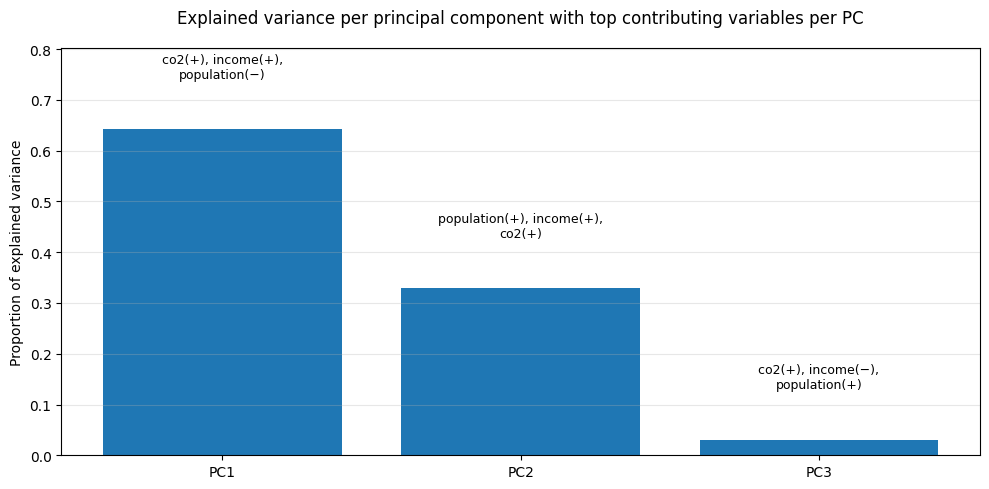

In [22]:
pca_3 = PCA(n_components=3, random_state=0).fit(Z_train[cont].values)
plot_pca_variance_with_top_features(pca_3, cont)

### PCA on continuous features (keep 95% variance, keep dummies as-is)

* We fit **PCA** on the **standardized continuous columns** from the **training set** only, asking for the **smallest number of components** that explains **≥95%** of the variance (`n_components=0.95`).

* We then **transform both train and test** with this same PCA (no leakage) to get `PCs_train` and `PCs_test`.

* Next, we **concatenate** these PCs with the **one-hot dummies** (which stay as 0/1 and are **not** part of PCA). This gives `Xpca_tr` / `Xpca_te`, the inputs we’ll feed to the models.

  > Rationale: running PCA only on continuous features avoids letting a large block of 0/1 dummy columns dominate the variance, while still preserving all categorical signals.

* The `print` tells you how many columns you end up using (PCs **plus** dummies).

* If there are **no continuous columns**, we skip PCA and just use the raw matrices (`Z_train`, `Z_test`).


In [23]:
if len(cont) > 0:
    pca95 = PCA(n_components=0.95, random_state=0).fit(Z_train[cont].values)
    PCs_train = pca95.transform(Z_train[cont].values)
    PCs_test  = pca95.transform(Z_test[cont].values)
    Xpca_tr = np.hstack([PCs_train, Z_train[dum].values]) if len(dum) > 0 else PCs_train
    Xpca_te = np.hstack([PCs_test,  Z_test[dum].values]) if len(dum) > 0 else PCs_test
    print("PCs:", Xpca_tr.shape[1], "(dummies included in the end)")
else:
    Xpca_tr = Z_train.values
    Xpca_te = Z_test.values
    pca95 = None

PCs: 201 (dummies included in the end)


### Visualize the PCA space colored by the target (life expectancy)

* We **rebuild the full design matrix** `Z_all` using the **same scaler fitted on the training set** (so continuous columns are standardized exactly like in training; dummies remain 0/1). The mask `disc_mask_all` marks which columns are discrete—kept for consistency.

* We then project **all rows** into PCA space using the **trained** `pca95` (fitted on train continuous features).
  `X_pca_all` contains **PC1, PC2, …** for every country, but here we’ll use **PC1 × PC2** for a 2D view.

* Finally, `plot_pca_heatmap_pc1_pc2_stat(...)` draws a **heatmap over the PC1–PC2 plane** where each cell’s color is the **mean life expectancy** of the points that fall into that cell (`stat="mean"`).
  The axis labels include the **% variance explained** by PC1/PC2 and the **top contributing variables** to each PC (based on loadings).

  * `bins=30` controls the grid resolution (more bins → finer detail).
  * `top_k=3` shows the three strongest variables shaping each PC.

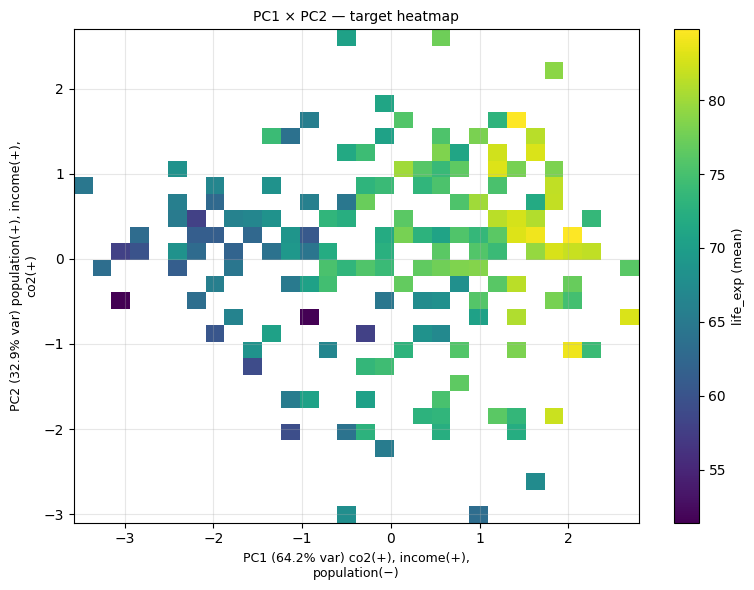

(<Figure size 800x600 with 2 Axes>,
 <Axes: title={'center': 'PC1 × PC2 — target heatmap'}, xlabel='PC1 (64.2% var) co2(+), income(+),\npopulation(−)', ylabel='PC2 (32.9% var) population(+), income(+),\nco2(+)'>)

In [24]:
Z_all, disc_mask_all = assemble_matrix(X_enc_raw, scaler, cont, dum)

X_pca_all = pca95.transform(Z_all[cont].values)

plot_pca_heatmap_pc1_pc2_stat(
    X_pca=X_pca_all,
    pca=pca95,
    feature_names=cont,
    z=y_full,
    z_label="life_exp",
    stat="mean",
    bins=30,
    top_k=3,
    wrap=42
)

### PCA on **all** features + correlation-circle biplot (PC1×PC2)

* `PCA(n_components=0.95, random_state=0).fit(Z_train.values)` fits PCA on **all columns** in `Z_train` (continuous **and** one-hot dummies), keeping the **smallest number of PCs** that explain **≥95%** of the total variance.

  > Note: including many 0/1 dummies can dominate variance; this is mainly for exploration/visualization.

* `plot_pca_correlation_biplot(...)` draws the **correlation circle** (biplot) for **PC1 vs PC2**:

  * `feature_names=Z_train.columns` labels each arrow with the original variable name.
  * `components=(0, 1)` selects **PC1** (x-axis) and **PC2** (y-axis).
  * `top_k=10` shows only the **10 longest arrows** (largest loadings) to keep the plot readable.
  * `discrete_mask=disc_mask_train` lets the function **style** dummies differently (visual cue); it doesn’t change the math.

Interpretation: each arrow points in the direction where that variable **increases**; its length shows how strongly the variable **loads** on PC1/PC2. Variables pointing in similar directions are **positively correlated**; opposite directions suggest **negative correlation**.


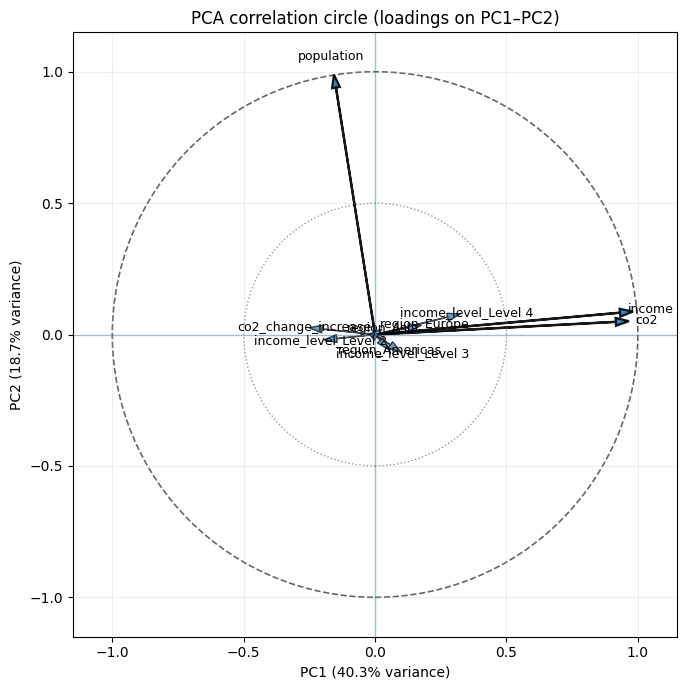

In [25]:
pca_all = PCA(n_components=0.95, random_state=0).fit(Z_train.values)
fig, ax = plot_pca_correlation_biplot(
    pca=pca_all,
    feature_names=Z_train.columns,
    components=(0,1),
    top_k=10,
    discrete_mask=disc_mask_train
)

### Rank features by how much they tell us about the target (Mutual Information)

* We compute **Mutual Information (MI)** between **each input column** in `Z_train` and the target `y_train` (*life expectancy*).
  Intuition: MI measures **how much uncertainty about the target is reduced** if you know a given feature. Higher MI ⇒ more informative.

* `discrete_features=disc_mask_train` tells the estimator which columns are **one-hot dummies** (discrete) and which are **continuous**, so each is handled appropriately.

* `mutual_info_regression` returns MI in **nats** (natural log). We convert to **bits** by dividing by `log(2)`—bits are easier to explain (“how many **bits** of uncertainty this feature removes”).

* We build a table with `feature` and `MI_bits`, **sort descending**, and show the **top 10**.

  > Note: This is **univariate** MI (one feature at a time). It’s great for a quick ranking, but it doesn’t remove overlap between features—use **mRMR** to balance relevance and redundancy.


In [26]:
mi_vals = mutual_info_regression(
    Z_train.values, y_train,
    discrete_features=disc_mask_train,
    random_state=0
)
mi_bits = mi_vals / np.log(2)
mi_df = pd.DataFrame({"feature": Z_train.columns, "MI_bits": mi_bits}).sort_values("MI_bits", ascending=False).reset_index(drop=True)
mi_df.head(10)

,feature,MI_bits
0,income,0.730532
1,co2,0.659252
2,income_level_Level 4,0.426687
3,region_Americas,0.275766
4,region_Europe,0.272770
5,co2_change_increase,0.200256
6,income_level_Level 2,0.200174
7,population,0.181849
8,income_level_Level 3,0.155558
9,region_Asia,0.009337


### Rank all features by how much they explain the target — with a readable chart

We call `plot_mi_ranking(...)` to compute **Mutual Information** (in **bits**) between **every feature** in `Z_all` and the target `y_full` (*life expectancy*), telling the function which columns are **discrete** vs **continuous** via `disc_mask_all`. The function returns:

* `mi_df_all`: a **full table** sorted by MI (highest first) — this has **all** features, not just those shown.
* `fig, ax`: the plotted chart.

Display tweaks so the figure stays readable even with lots of one-hot columns:

* `max_bars=30`: show only the **top-30** bars in the chart (the table still has everything).
* `strip_prefixes=["country_"]`: remove that prefix from dummy names to **shorten labels**.
* `label_max_chars=24`: **truncate** very long labels with an ellipsis.
* `height_per_bar=0.3` and `figsize=(10, 6)`: give each bar more vertical space and make the figure wider.
* `annotate=False`: skip numeric labels on bars to reduce clutter.

Interpretation: features near the top **reduce more uncertainty** about life expectancy on their own (univariate view). For redundancy-aware selection, compare with **mRMR**.


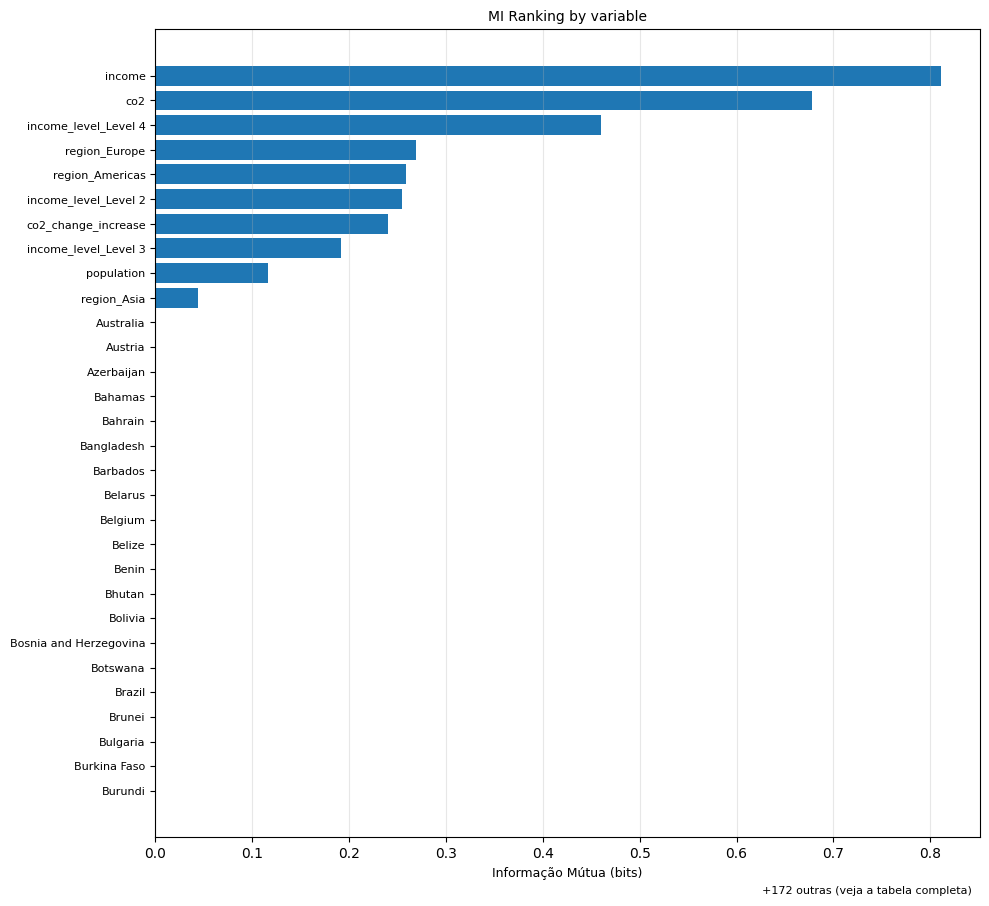

In [27]:
mi_df_all, fig, ax = plot_mi_ranking(
    X=Z_all,
    y=y_full,
    task="reg",
    discrete_features=disc_mask_all,
    units="bits",
    annotate=False,
# ajustes para legibilidade:
    max_bars=30,
    strip_prefixes=["country_"], # remove prefixo dos dummies
    label_max_chars=24,          # corta nomes longos
    height_per_bar=0.3,
    figsize=(10, 6)              # deixa a figura mais larga
)

### Entropy waterfall: explain how multiple features reduce uncertainty in `life_exp`

1. **Choose the feature order**
   We pick an ordering `order` for the variables we’ll add one by one. Using **mRMR** (or a MI ranking) is recommended because it balances **relevance** with **low redundancy**.

```python
order = top_mrmr[:10]  # or: order = mi_df_all.head(8)["feature"].tolist()
```

2. **Run the waterfall decomposition**
   `plot_entropy_decomposition_waterfall(...)` applies the **chain rule of information** to show, step by step, how much **uncertainty in `life_exp`** is removed as we add each feature in `order`.

* `y=df["life_exp"]`: the target we want to explain.
* `X_df=X_enc_raw`: the **model-ready** feature table (one-hot + continuous), **not scaled**—the function discretizes internally for the information calculations.
* `continuous_cols=cont`: tells the function which columns are **continuous** (so they can be discretized by quantiles); everything else is treated as discrete/dummy.
* `order=order`: use our chosen feature order; if `None`, the function will rank by **univariate MI** and take `top_k`.
* `bins_y=6`, `bins_x=5`: number of **quantile bins** used to discretize `life_exp` and continuous features (helps make MI in **bits** stable and easy to explain).
* `strip_prefixes=["country_"]`: shortens long one-hot names in the plot.

The output shows a **horizontal waterfall**:

* each blue bar is the **marginal information gain** $I(Y; X_i \mid S)$ when adding feature $X_i$ given the set $S$ already chosen;
* the final red bar is the **leftover uncertainty** $H(Y \mid S)$;
* the text footer reports **total** $H(Y)$, the accumulated information $I(Y; S)$, and the residual $H(Y\mid S)$ — all in **bits**.

The function also returns a dict (`info_wf`) with these numbers and a per-feature list of gains for your slides or logs.


In [29]:
k = min(10, X_enc_raw.shape[1])
top_mrmr = mrmr_greedy_regression(X_enc_raw, y_full, k=k)
top_mi = mi_df.head(k)["feature"].tolist()
print("Top por MI:", top_mi)
print("Top por mRMR:", top_mrmr)

Top por MI: ['income', 'co2', 'income_level_Level 4', 'region_Americas', 'region_Europe', 'co2_change_increase', 'income_level_Level 2', 'population', 'income_level_Level 3', 'region_Asia']
Top por mRMR: ['income', 'region_Americas', 'co2_change_increase', 'co2', 'income_level_Level 4', 'region_Europe', 'population', 'income_level_Level 2', 'country_Sudan', 'region_Asia']


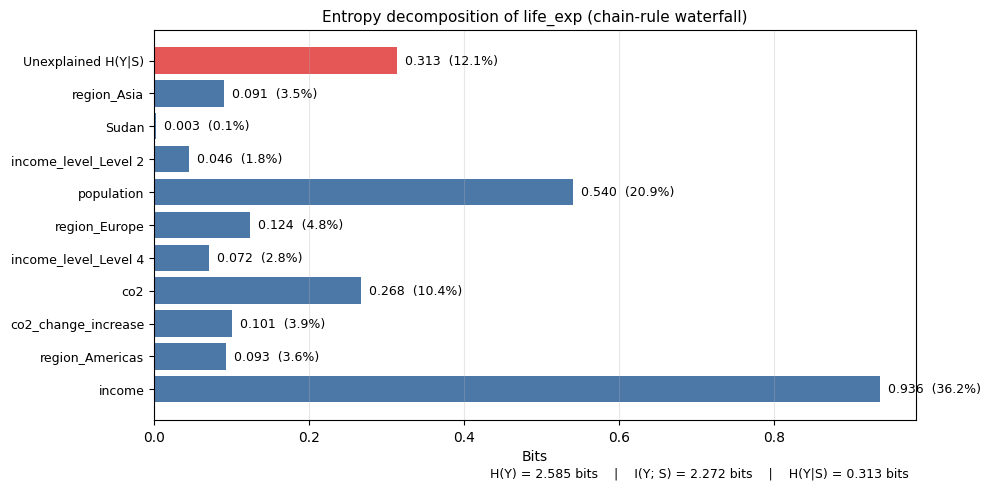

In [30]:
order = top_mrmr[:10]   # ou: order = mi_df_all.head(8)["feature"].tolist()

info_wf, fig, ax = plot_entropy_decomposition_waterfall(
    y=df["life_exp"],
    X_df=X_enc_raw,
    continuous_cols=cont,           # da sua meta
    order=order,                    # usa essa ordem; se None, ele escolhe por MI
    top_k=None,
    bins_y=6,
    bins_x=5,
    strip_prefixes=["country_"]
)

### Pick how many features to keep and compare two selectors (MI vs. mRMR)

* We choose a target number of features, `k` (up to **10** here). This is the size of the reduced feature set we want to keep.
* **`top_mi`**: take the **k highest** features by *Mutual Information* (relevance-only, one feature at a time).
* **`top_mrmr`**: run a greedy **mRMR** selector that balances **relevance** (high MI with the target) and **low redundancy** (low overlap with features already chosen).
* Finally, we print both lists to **contrast** what each method picks.

> Note: For a fair workflow, feature selection is usually done on the **training set** only (to avoid peeking at the test data). Using the full dataset here is okay for a quick demo, but for evaluation you should select on train and apply the chosen features to test.


### Compare all strategies and collect the scores

* We loop over four input setups: **All**, **Top-k MI**, **Top-k mRMR**, and **PCA95%+Dummies**.
  For each one, we call `eval_models_reg(...)`, which trains **Linear Regression** and **Random Forest Regressor** and returns their **R²** and **RMSE** on the test set.

* All these results are merged into a single dictionary called `results`, with keys like
  `"All | LR R2"`, `"All | LR RMSE"`, `"Top-10 mRMR | RF R2"`, etc.

* Then we extract just the **R² entries**:

  * `r2_labels`: the names of the R² metrics (one per model/strategy),
  * `r2_vals`: the corresponding **R² numbers**.

These arrays are handy for plotting a **bar chart** of R² or for quickly spotting which strategy performed best.

In [31]:
Xmi_tr, Xmi_te = X_train_raw[top_mi].values, X_test_raw[top_mi].values
Xmrmr_tr, Xmrmr_te = X_train_raw[top_mrmr].values, X_test_raw[top_mrmr].values
results = {}
for tag, (tr, te) in {
    "All": (Xa_tr, Xa_te),
    f"Top-{k} MI": (Xmi_tr, Xmi_te),
    f"Top-{k} mRMR": (Xmrmr_tr, Xmrmr_te),
    "PCA95%+Dummies": (Xpca_tr, Xpca_te),
}.items():
    results.update(eval_models_reg(tr, te, y_train, y_test, tag))

# R²
r2_labels = [k for k in results if k.endswith("R2")]
r2_vals = [results[k][0] for k in r2_labels]
r2_labels, r2_vals

(['All | LR R2',
  'All | RF R2',
  'Top-10 MI | LR R2',
  'Top-10 MI | RF R2',
  'Top-10 mRMR | LR R2',
  'Top-10 mRMR | RF R2',
  'PCA95%+Dummies | LR R2',
  'PCA95%+Dummies | RF R2'],
 [0.792048129847709,
  0.7443377235693853,
  0.7895237777088393,
  0.736064576170449,
  0.7883825197274058,
  0.7371317092582927,
  0.7490280471474898,
  0.7383468516925431])

### Visualize R² across strategies/models

This cell draws a **horizontal bar chart** comparing the **R²** scores for each *strategy × model* pair (the labels like `"All | LR R2"`, `"Top-k mRMR | RF R2"`, etc. came from the previous step).

* `plt.figure(figsize=(9, 5))`: sets the figure size.
* `plt.barh(r2_labels, r2_vals)`: plots **R²** as horizontal bars (good for long labels).
* Axis/title: `xlabel("R²")`, `title("R² por estratégia/modelo")`.
* `grid(True, axis="x")`: adds a light grid to help compare values.
* `tight_layout()`: reduces overlaps between text and the plot.
* `show()`: renders the chart.

> Read it as: **higher R² is better**. The longest bar shows the best-performing strategy/model.


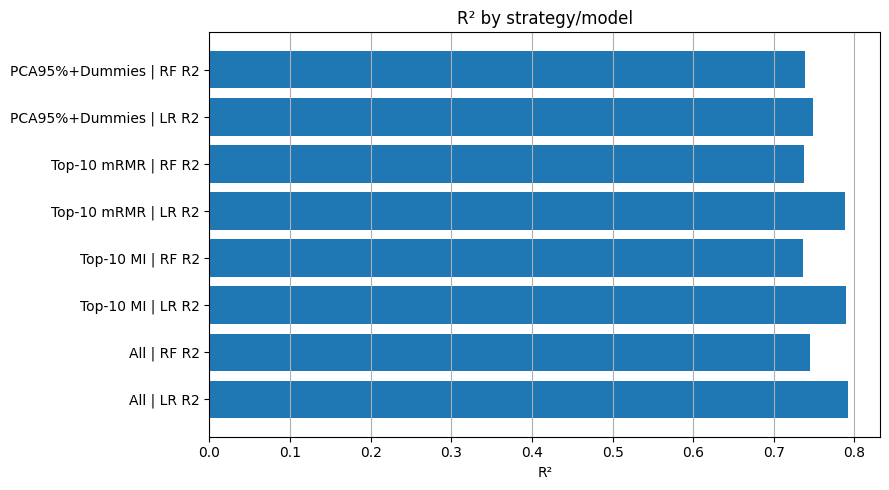

In [32]:
plt.figure(figsize=(9, 5))
plt.barh(r2_labels, r2_vals)
plt.xlabel("R²")
plt.title("R² by strategy/model")
plt.grid(True, axis="x")
plt.tight_layout()
plt.show()

### Best model fit and “predicted vs. actual” check

* From the previous step we already know which **strategy × model** performed best (`best_tag`).
  `get_sets_for_tag(best_tag)` returns the matching **training** (`Xtr`) and **test** (`Xte`) inputs.

* We instantiate the chosen model:

  * if `best_tag` contains `"LR"`, use **Linear Regression**;
  * otherwise use a **Random Forest Regressor**.

* We **fit** the model on the training data and **predict** life expectancy for the test set.
  Then we compute **RMSE** (lower is better) as an easy-to-explain error metric.

* The scatter plot shows **Predicted vs. Actual**:

  * each dot = one country in the test set;
  * the **diagonal line** is the ideal `prediction = actual`;
    dots close to it mean **accurate predictions**;
  * systematic shifts above/below the line suggest **bias**;
    wide vertical spread suggests **higher error/variance**.


In [34]:
best_idx = int(np.argmax(r2_vals))
best_tag = r2_labels[best_idx]
print("Best option:", best_tag, "-> R² =", round(r2_vals[best_idx], 4))

Best option: All | LR R2 -> R² = 0.792


Best model RMSE: 3.157


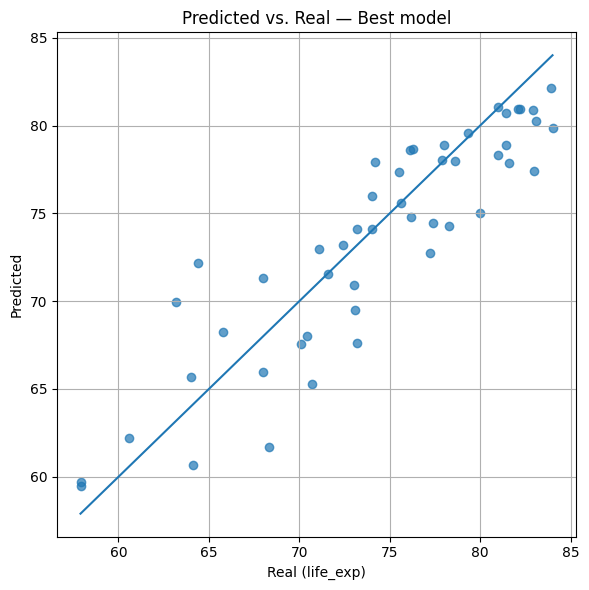

In [36]:
Xtr, Xte = get_sets_for_tag(best_tag)
model = LinearRegression() if "LR" in best_tag else RandomForestRegressor(n_estimators=300, random_state=0, n_jobs=-1)
model.fit(Xtr, y_train)
yhat = model.predict(Xte)

rmse_best = RMSE(y_test, yhat)
print("Best model RMSE:", round(rmse_best, 3))

plt.figure(figsize=(6, 6))
plt.scatter(y_test, yhat, alpha=0.7)
lims = [min(y_test.min(), yhat.min()), max(y_test.max(), yhat.max())]
plt.plot(lims, lims)
plt.xlabel("Real (life_exp)")
plt.ylabel("Predicted")
plt.title("Predicted vs. Real — Best model")
plt.grid(True)
plt.tight_layout()
plt.show()


## Conclusion and suggested next steps

- **PCA** gave us a compact view of the continuous drivers and supported intuitive visuals (heatmaps, biplots).
- **Information Theory** (MI/mRMR) highlighted which inputs *actually* reduce uncertainty in the target, and how redundancy creeps in.

**Practical takeaways for business teams:**
- Start with **MI ranking** to get a quick sense of what matters.
- Use **mRMR** to select a compact set with low overlap.
- Use **PCA** when you have many continuous metrics that are correlated, especially to build **dashboards** and **compressed models**.

**Where to go next (dimensionality reduction & selection):**
- **Supervised:** L1/Lasso, Elastic Net, tree‑based importance, recursive feature elimination (RFE).
- **Unsupervised:** t‑SNE/UMAP (visualization), **ICA** (independent components), **NMF** (non‑negative matrix factorization).
- **Representation learning:** **Autoencoders** (shallow or variational) to learn compact embeddings.
- **Information‑theoretic:** conditional MI estimators, information bottleneck, MDL (minimum description length).
- **Robust modeling:** cross‑validation, temporal splits, target leakage checks, permutation importance, SHAP for explainability.

Choose the tool that balances **performance**, **simplicity**, and **stakeholder understanding**.
